In [1]:
!pip install keras_vggface
!pip install keras_applications
!pip install mtcnn

import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, AUC
from tensorflow.math import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
from tqdm import tqdm
from mtcnn.mtcnn import MTCNN
from keras.preprocessing import image
from keras import Model
from keras.layers import Input
# from keras_vggface.vggface import VGGFace
# from keras_vggface import utils

In [2]:
TRAINING_DIR = "C:/Users/cheta/Downloads/real_fake_splitted_new/train/"
TEST_DIR = "C:/Users/cheta/Downloads/real_fake_splitted_new/test/"
VAL_DIR="C:/Users/cheta/Downloads/real_fake_splitted_new/val/"

print(f'Total training images REAL: {len(os.listdir("C:/Users/cheta/Downloads/real_fake_splitted_new/train/real/"))}')
print(f'Total training images FAKE: {len(os.listdir("C:/Users/cheta/Downloads/real_fake_splitted_new/train/fake/"))}\n')

print(f'Total test images REAL: {len(os.listdir("C:/Users/cheta/Downloads/real_fake_splitted_new/test/real/"))}')
print(f'Total test images FAKE: {len(os.listdir("C:/Users/cheta/Downloads/real_fake_splitted_new/test/fake/"))}\n')

print(f'Total test images REAL: {len(os.listdir("C:/Users/cheta/Downloads/real_fake_splitted_new/val/real/"))}')
print(f'Total test images FAKE: {len(os.listdir("C:/Users/cheta/Downloads/real_fake_splitted_new/val/fake/"))}')


Total training images REAL: 16864
Total training images FAKE: 16768

Total test images REAL: 2109
Total test images FAKE: 2096

Total test images REAL: 2108
Total test images FAKE: 2096


In [3]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

img_size = 300
img_batch = 64

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    subset='training',
    target_size=(img_size, img_size),
    shuffle=True,
    class_mode='binary',
    batch_size=img_batch
)

validation_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    subset='validation',
    target_size=(img_size, img_size),
    shuffle=True,
    class_mode='binary',
    batch_size=img_batch
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_size, img_size),
    class_mode='binary',
    batch_size=img_batch,
    shuffle=False
)

Found 26907 images belonging to 2 classes.
Found 6725 images belonging to 2 classes.
Found 4205 images belonging to 2 classes.


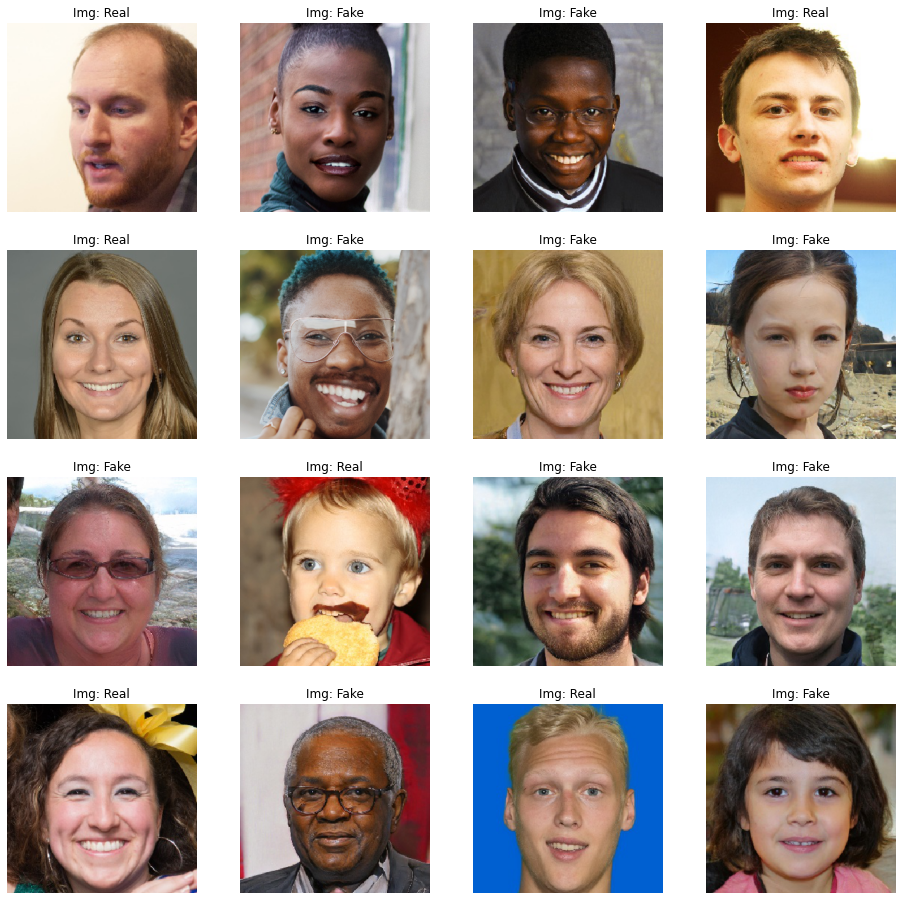

In [4]:
labels = {1.0: 'Real', 0.0: 'Fake'}

for images, images_labels in train_generator:
    plt.figure(figsize=(16, 16))
    
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.title(f'Img: {labels[images_labels[i]]}')
        plt.imshow(np.uint8(255 * images[i]))
        plt.axis('off')
    break

In [5]:
model = Sequential([

    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    Flatten(),

    # 384 neuron hidden layer
    Dense(384, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 identifies a fake face and 1 a real face
    Dense(1, activation='sigmoid')

])

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_generator,
    epochs=70,
    steps_per_epoch=75,
    validation_data=validation_generator,
    verbose=1
    #callbacks=callback
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

Text(0.5, 0, 'Class')

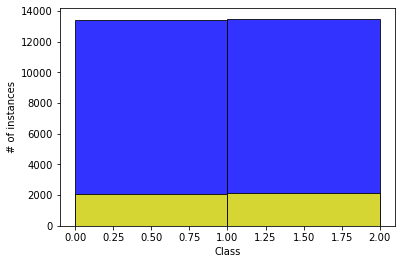

In [6]:
h1 = plt.hist(train_generator.classes, bins=range(0,3), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(test_generator.classes,  bins=range(0,3), alpha=0.8, color='yellow', edgecolor='black')
#h3 = plt.hist(validation_generator.classes,  bins=range(0,3), alpha=0.8, color='green', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')

Text(0.5, 0, 'Class')

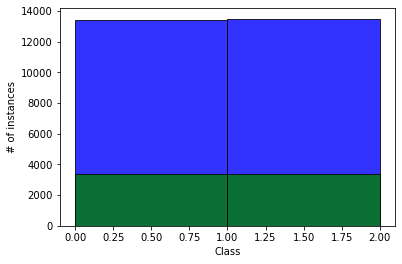

In [7]:
h1 = plt.hist(train_generator.classes, bins=range(0,3), alpha=0.8, color='blue', edgecolor='black')
h3 = plt.hist(validation_generator.classes,  bins=range(0,3), alpha=0.8, color='green', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')

In [8]:
model.save("cnn_model.hdf5")

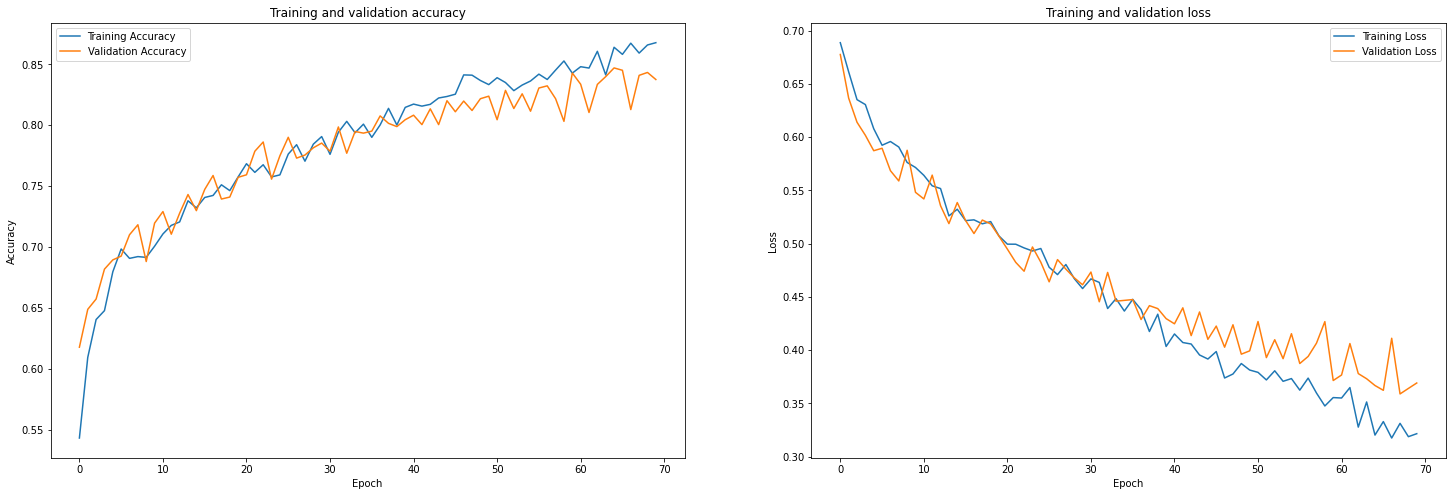

In [9]:
plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [10]:
metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
index_model_checkpoint = np.argmin(history.history['val_loss'])
[f'Best {metric}: {history.history[metric][index_model_checkpoint]:.2f}' for metric in metrics]

['Best accuracy: 0.86',
 'Best val_accuracy: 0.84',
 'Best loss: 0.33',
 'Best val_loss: 0.36']

In [11]:
def load_and_test_model(model_name, test_set, display_model_summary=False):
    try:
        loaded_model = tf.keras.models.load_model(f'{model_name}.hdf5')
    except OSError:
        print('The model called does not exist. Testing for the last saved model.')
        loaded_model = tf.keras.models.load_model('model.hdf5')
    if display_model_summary:
        loaded_model.summary()
    test_loss, test_acc = loaded_model.evaluate(test_set)
    print(f'Test loss: {round(test_loss, 2)}, Test accuracy: {round(test_acc * 100, 2)}')


In [12]:
load_and_test_model('cnn_model', test_generator)

66/66 [==============================] - 108s 2s/step - loss: 0.3935 - accuracy: 0.8288
Test loss: 0.39, Test accuracy: 82.88


In [13]:
def calculate_model_performance_metrics(model_name, test_dataset, transfer_ml=False, model_version=0,
                                        show_plots=False):
    
    try:
        loaded_model = tf.keras.models.load_model(f'{model_name}.hdf5')
        print(f'Calculating performance metrics for model {model_name}')
    except OSError:
        print('The model called does not exist. Testing for the last saved model.')
        loaded_model = tf.keras.models.load_model('model.hdf5')

    if transfer_ml and model_version != 0:
        test_images, true_labels = test_dataset.as_numpy_iterator().next()
        test_images = utils.preprocess_input(test_images, version=model_version)
        predictions_sigmoid = loaded_model.predict(test_images, verbose=1)
    else:
        true_labels = test_dataset.labels
        predictions_sigmoid = loaded_model.predict(test_dataset, verbose=1)
    
    false_positives_negatives = []
    lower_bound_threshold = 0.2
    upper_bound_threshold = 0.7
    step = 0.001

    sigmoid_threshold = np.arange(lower_bound_threshold, upper_bound_threshold, step)

    for threshold in sigmoid_threshold:
        predictions_binary = tf.where(predictions_sigmoid > threshold, 1, 0)
        conf_matrix = confusion_matrix(true_labels, predictions_binary)
        false_positives_negatives.append(conf_matrix[0][1] + conf_matrix[1][0])

    min_threshold = sigmoid_threshold[np.argmin(false_positives_negatives)]
    print(f'Minimizer of false positives and false negatives: {min_threshold:.3f}')

    metrics_options = {
        'Precision': Precision,
        'Recall': Recall,
        'True Positives': TruePositives,
        'True Negatives': TrueNegatives,
        'False Positives': FalsePositives,
        'False Negatives': FalseNegatives
    }

    def disp_metrics(metric, threshold_value=min_threshold, verbose=False):
        metrics = metrics_options[metric](thresholds=threshold_value)
        metrics.update_state(true_labels, predictions_sigmoid)
        result = metrics.result().numpy()
        if verbose:
            print(f'{metric}: {result:.3f}')
        return result

    bin_acc = BinaryAccuracy(threshold=min_threshold)
    bin_acc.update_state(true_labels, predictions_sigmoid)
    print(f'Binary Accuracy: {bin_acc.result().numpy():.3f}')

    for metric in metrics_options.keys():
        disp_metrics(metric, verbose=True)

    rights = disp_metrics('True Positives') + disp_metrics('True Negatives')
    wrongs = disp_metrics('False Positives') + disp_metrics('False Negatives')
    print(f'Number of right guesses: {rights:.3f}')
    print(f'Number of wrong guesses: {wrongs:.3f}')

    auc = AUC()
    auc.update_state(true_labels, predictions_sigmoid)
    auc = auc.result().numpy()
    print(f'Area under curve ROC: {auc:.3f}')

    precision = disp_metrics('Precision')
    recall = disp_metrics('Recall')

    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f'F1-Score: {f1_score:.3f}')


    if show_plots:
        
        plt.figure(figsize=(18, 14))
    
        plt.subplot(2, 2, 1)
        plt.plot(sigmoid_threshold, false_positives_negatives, linewidth=3)
        plt.title('Sum of false positives and false negatives as a function of sigmoid threshold')
        plt.xlabel('Sigmoid threshold')
        plt.ylabel('False positives + False negatives')

        plt.subplot(2, 2, 2)
        cm = confusion_matrix(true_labels, tf.where(predictions_sigmoid > min_threshold, 1, 0))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title(f'Confusion matrix @{min_threshold:.3f}')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

        plt.subplot(2, 2, 3)
        false_positive_rate, true_positive_rate, _ = roc_curve(true_labels, predictions_sigmoid)
        plt.plot(false_positive_rate, true_positive_rate, linewidth=4)
        plt.title(f'Receiver Operating Characteristic curve for AUC: {auc:.3f}')
        plt.xlabel('False positive rate')
        plt.ylabel('True positives rate')
        plt.grid(True)

        plt.subplot(2, 2, 4)
        prec, rec, _ = precision_recall_curve(true_labels, predictions_sigmoid)
        plt.plot(rec, prec, linewidth=4)
        avg_precision_score = average_precision_score(true_labels, predictions_sigmoid)
        plt.title(f'Precision-Recall curve | Average precision score: {avg_precision_score:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid(True)
    
    return min_threshold


Calculating performance metrics for model cnn_model
66/66 [==============================] - 90s 1s/step
Minimizer of false positives and false negatives: 0.569
Binary Accuracy: 0.834
Precision: 0.820
Recall: 0.857
True Positives: 1807.000
True Negatives: 1699.000
False Positives: 397.000
False Negatives: 302.000
Number of right guesses: 3506.000
Number of wrong guesses: 699.000
Area under curve ROC: 0.910
F1-Score: 0.838


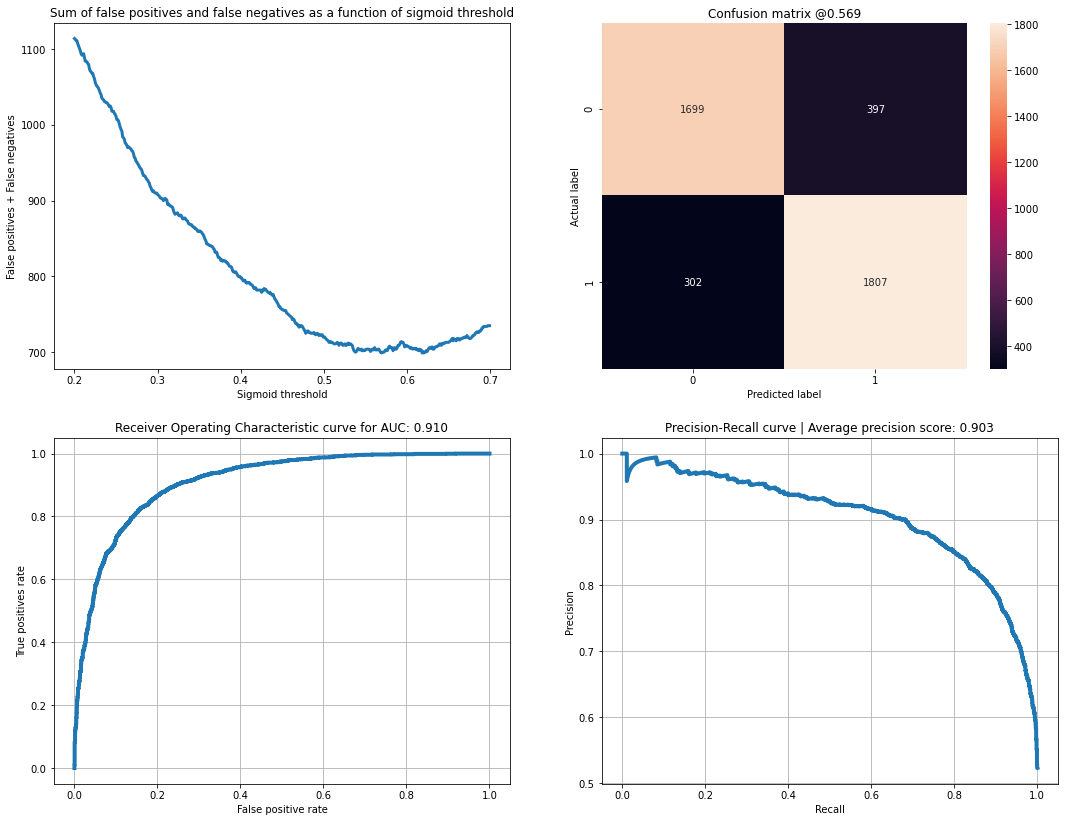

In [14]:
min_threshold = calculate_model_performance_metrics('cnn_model', test_generator, show_plots=True)

Found 4205 images belonging to 2 classes.
1/1 [==============================] - 1s 682ms/step


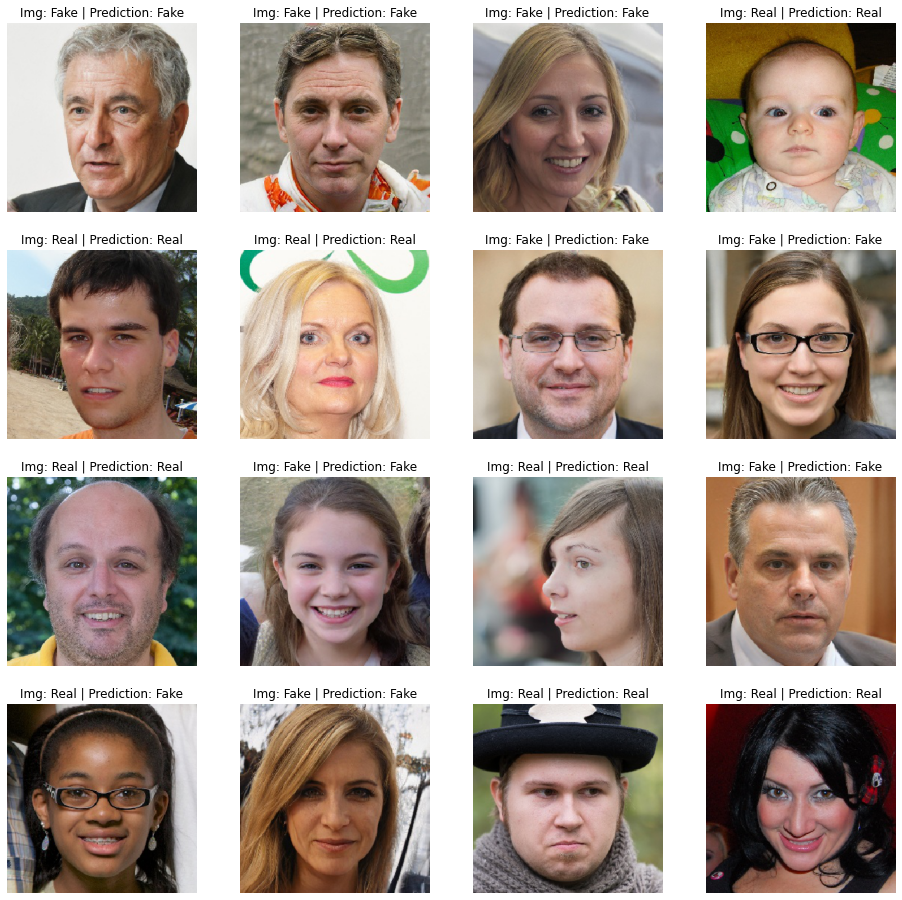

In [15]:
labels = {1.0: 'Real', 0.0: 'Fake'}

test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=(img_size, img_size), class_mode='binary')
loaded_model = tf.keras.models.load_model('cnn_model.hdf5')

for images, images_labels in test_generator:
    plt.figure(figsize=(16, 16))
    predictions = tf.where(loaded_model.predict(images) > min_threshold, 1, 0)
    predictions = tf.reshape(predictions, [-1]).numpy()

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.title(f'Img: {labels[images_labels[i]]} | Prediction: {labels[predictions[i]]}')
        plt.imshow(np.uint8(255 * images[i]))
        plt.axis('off')
    break